<a href="https://colab.research.google.com/github/kthanikonda/Artificial-Intelligence-Project/blob/main/Distilbert_LogisticRegression_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install psutil pandas matplotlib seaborn scikit-learn datasets transformers google-colab memory-profiler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset, Dataset
from google.colab import files  # For file upload in Colab

# Function to upload and load CSV file
def load_csv():
    print("Please upload the CSV file for sentiment analysis:")
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    return file_name

# Function to prepare the dataset
def prepare_dataset(file_name):
    dataset = load_dataset("csv", data_files={"train": file_name, "test": file_name}, split="train")
    sentiment_mapping = {'positive': 1, 'negative': 0}
    dataset = dataset.map(lambda x: {"label": sentiment_mapping[x["sentiment"]]})
    X = dataset['review']
    y = dataset['label']
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_dataset = Dataset.from_dict({"text": X_train, "label": y_train})
    test_dataset = Dataset.from_dict({"text": X_test, "label": y_test})
    return train_dataset, test_dataset

# Load CSV and prepare dataset
file_name = load_csv()
train_dataset, test_dataset = prepare_dataset(file_name)

Please upload the CSV file for sentiment analysis:


Saving imdb_sentiment_3000.csv to imdb_sentiment_3000.csv


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

Training Logistic Regression model...
Training DistilBERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2399 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.521300,0.457109
2,0.396400,0.489850
3,0.151500,0.625369


Epoch,Training Loss,Validation Loss
1,0.619300,0.642528
2,0.305000,0.657899
3,0.190800,0.673081


Logistic Regression Results:
Accuracy: 0.840000
Precision: 0.839844
Recall: 0.839662
F1-Score: 0.839744
Training Time: 0.813035 seconds
Inference Time: 0.183466 seconds
Peak Memory Usage: 3.343750 MB

DistilBERT Results:
Accuracy: 0.816667
Precision: 0.821142
Recall: 0.814339
F1-Score: 0.815056
Training Time: 438.870636 seconds
Inference Time: 9.146107 seconds
Peak Memory Usage: 391.015625 MB


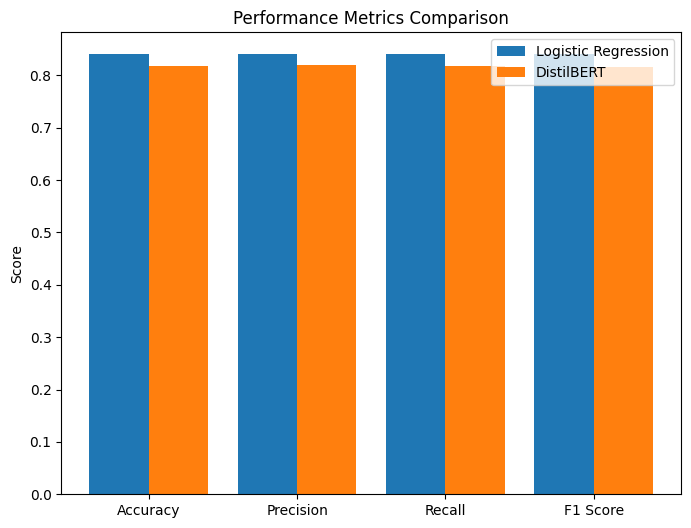

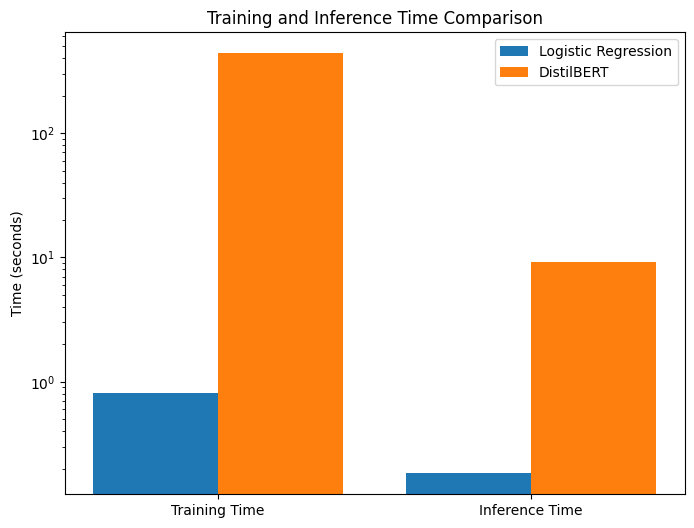

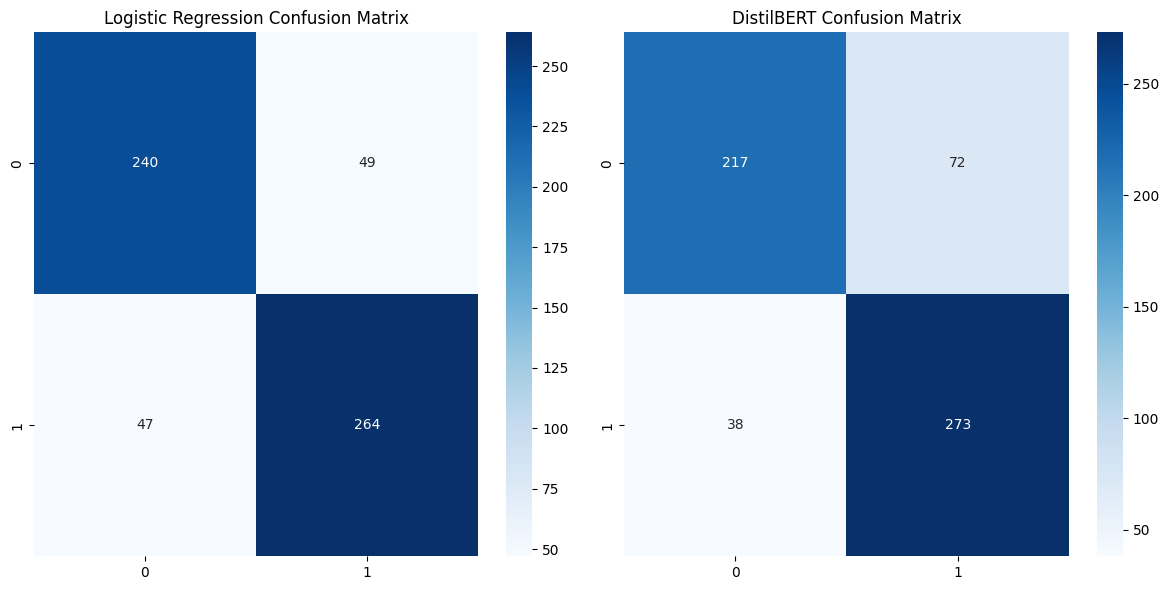

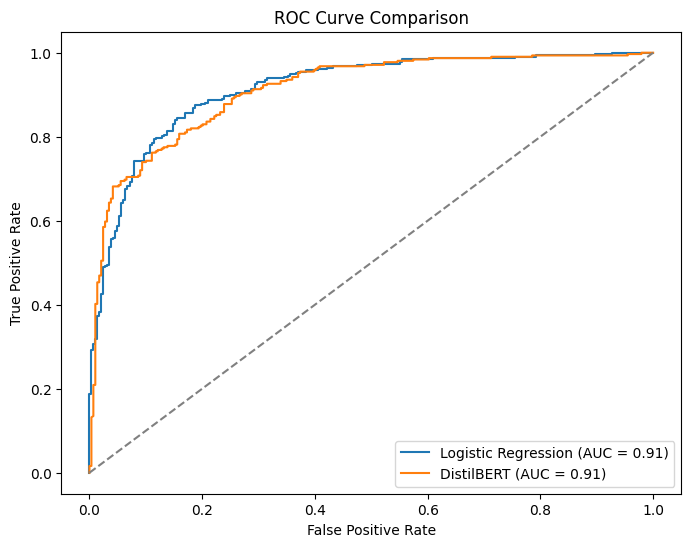

In [ ]:
import time
from memory_profiler import memory_usage
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Function to train Logistic Regression
def train_logistic_regression(X_train, X_test, y_train, y_test):
    # Vectorizer with a maximum of 5000 features
    vectorizer = TfidfVectorizer(max_features=5000)

    # Logistic Regression model
    model = LogisticRegression()

    # Measure memory usage during training and inference
    def train():
        X_train_tfidf = vectorizer.fit_transform(X_train)
        model.fit(X_train_tfidf, y_train)

    # Measure memory usage of training
    mem_usage = memory_usage(train, interval=0.1)
    peak_memory = max(mem_usage) - min(mem_usage)

    # Measure training time
    start_time = time.time()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    model.fit(X_train_tfidf, y_train)
    training_time = time.time() - start_time

    # Measure inference time
    start_time = time.time()
    X_test_tfidf = vectorizer.transform(X_test)
    y_pred = model.predict(X_test_tfidf)
    inference_time = time.time() - start_time

    # Calculate probabilities for ROC curve and AUC
    probabilities = model.predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    auc_score = auc(fpr, tpr)

    # Confusion matrix and classification metrics
    cm = confusion_matrix(y_test, y_pred)
    metrics = classification_report(y_test, y_pred, output_dict=True)
    metrics["roc_curve"] = (fpr, tpr)
    metrics["auc_score"] = auc_score

    return metrics, cm, training_time, inference_time, peak_memory

# Function to train DistilBERT
def train_distilbert(train_dataset, test_dataset):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

    # Tokenize datasets
    def tokenize_function(example):
        return tokenizer(example["text"], padding="max_length", truncation=True)

    train_dataset = train_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",  # Evaluate at the end of each epoch
        save_strategy="epoch",       # Save model after each epoch
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=50,
        report_to="none",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    # Measure memory usage during training
    def train():
        trainer.train()

    # Track memory usage
    mem_usage = memory_usage(train, interval=0.1)
    peak_memory = max(mem_usage) - min(mem_usage)

    # Measure training time
    start_time = time.time()
    trainer.train()  # Perform the training
    training_time = time.time() - start_time

    # Measure inference time
    start_time = time.time()
    predictions = trainer.predict(test_dataset)
    inference_time = time.time() - start_time

    # Process predictions and calculate metrics
    logits = predictions.predictions
    labels = predictions.label_ids
    probabilities = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    auc_score = auc(fpr, tpr)

    cm = confusion_matrix(labels, logits.argmax(axis=1))
    metrics = classification_report(labels, logits.argmax(axis=1), output_dict=True)
    metrics["roc_curve"] = (fpr, tpr)  # ROC curve data
    metrics["auc_score"] = auc_score

    return metrics, cm, training_time, inference_time, peak_memory

# Main function to execute both models and output the results
def execute_models():
    # Assuming train_dataset and test_dataset are prepared already
    # Example: train_dataset and test_dataset are pandas DataFrames or Huggingface Datasets

    # Train Logistic Regression model
    print("Training Logistic Regression model...")
    metrics_lr, cm_lr, training_time_lr, inference_time_lr, peak_memory_lr = train_logistic_regression(
        train_dataset["text"], test_dataset["text"], train_dataset["label"], test_dataset["label"]
    )

    # Train DistilBERT model
    print("Training DistilBERT model...")
    metrics_distilbert, cm_distilbert, training_time_distilbert, inference_time_distilbert, peak_memory_distilbert = train_distilbert(
        train_dataset, test_dataset
    )

    # Output results for Logistic Regression
    print("Logistic Regression Results:")
    print(f"Accuracy: {metrics_lr['accuracy']:.6f}")
    print(f"Precision: {metrics_lr['macro avg']['precision']:.6f}")
    print(f"Recall: {metrics_lr['macro avg']['recall']:.6f}")
    print(f"F1-Score: {metrics_lr['macro avg']['f1-score']:.6f}")
    print(f"Training Time: {training_time_lr:.6f} seconds")
    print(f"Inference Time: {inference_time_lr:.6f} seconds")
    print(f"Peak Memory Usage: {peak_memory_lr:.6f} MB")

    # Output results for DistilBERT
    print("\nDistilBERT Results:")
    print(f"Accuracy: {metrics_distilbert['accuracy']:.6f}")
    print(f"Precision: {metrics_distilbert['macro avg']['precision']:.6f}")
    print(f"Recall: {metrics_distilbert['macro avg']['recall']:.6f}")
    print(f"F1-Score: {metrics_distilbert['macro avg']['f1-score']:.6f}")
    print(f"Training Time: {training_time_distilbert:.6f} seconds")
    print(f"Inference Time: {inference_time_distilbert:.6f} seconds")
    print(f"Peak Memory Usage: {peak_memory_distilbert:.6f} MB")

    # Call plotting functions to generate the graphs last
    plot_metrics(metrics_lr, metrics_distilbert)
    plot_training_inference(training_time_lr, inference_time_lr, training_time_distilbert, inference_time_distilbert)
    plot_confusion_matrices(cm_lr, cm_distilbert)
    plot_roc_curves(metrics_lr, metrics_distilbert)

# Separate plotting functions

def plot_metrics(metrics_lr, metrics_distilbert):
    categories = ["Accuracy", "Precision", "Recall", "F1 Score"]
    lr_values = [metrics_lr["accuracy"], metrics_lr["weighted avg"]["precision"], metrics_lr["weighted avg"]["recall"], metrics_lr["weighted avg"]["f1-score"]]
    distilbert_values = [metrics_distilbert["accuracy"], metrics_distilbert["weighted avg"]["precision"], metrics_distilbert["weighted avg"]["recall"], metrics_distilbert["weighted avg"]["f1-score"]]

    plt.figure(figsize=(8, 6))
    x = range(len(categories))
    plt.bar(x, lr_values, width=0.4, label="Logistic Regression", align="center")
    plt.bar([p + 0.4 for p in x], distilbert_values, width=0.4, label="DistilBERT", align="center")
    plt.xticks([p + 0.2 for p in x], categories)
    plt.ylabel("Score")
    plt.title("Performance Metrics Comparison")
    plt.legend()
    plt.show()

def plot_training_inference(training_time_lr, inference_time_lr, training_time_distilbert, inference_time_distilbert):
    categories = ["Training Time", "Inference Time"]
    lr_values = [training_time_lr, inference_time_lr]
    distilbert_values = [training_time_distilbert, inference_time_distilbert]

    plt.figure(figsize=(8, 6))
    x = range(len(categories))
    plt.bar(x, lr_values, width=0.4, label="Logistic Regression", align="center")
    plt.bar([p + 0.4 for p in x], distilbert_values, width=0.4, label="DistilBERT", align="center")
    plt.xticks([p + 0.2 for p in x], categories)
    plt.ylabel("Time (seconds)")
    plt.title("Training and Inference Time Comparison")
    plt.yscale("log")  # Add logarithmic scale
    plt.legend()
    plt.show()

def plot_confusion_matrices(cm_lr, cm_distilbert):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Logistic Regression Confusion Matrix")
    sns.heatmap(cm_distilbert, annot=True, fmt="d", cmap="Blues", ax=axes[1])
    axes[1].set_title("DistilBERT Confusion Matrix")
    plt.tight_layout()
    plt.show()

def plot_roc_curves(metrics_lr, metrics_distilbert):
    roc_lr, auc_lr = metrics_lr["roc_curve"], metrics_lr["auc_score"]
    roc_distilbert, auc_distilbert = metrics_distilbert["roc_curve"], metrics_distilbert["auc_score"]

    plt.figure(figsize=(8, 6))
    plt.plot(roc_lr[0], roc_lr[1], label=f"Logistic Regression (AUC = {auc_lr:.2f})")
    plt.plot(roc_distilbert[0], roc_distilbert[1], label=f"DistilBERT (AUC = {auc_distilbert:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# Run the models
execute_models()
